### CE 314/887 Assignment 2 Text classification 
##### Diego Armando Salinas Lugo ds24353 2401168


### The libraries about to use to perform the desired tasks.

In [1]:
# General Libraries for reading and manipulation 
import pandas as pd
import numpy as np

# For text Preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import nltk
nltk.download('stopwords')  # To ensure stopwords are available

# Model Training and Evaluation
from xgboost import XGBClassifier  # Import XGBoost Classifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve
)

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore Warnings (to dont show them)
import warnings
warnings.filterwarnings("ignore")

#For the text analysis 

from wordcloud import WordCloud 
from collections import Counter


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Salin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1: Reading the file, incorporating the instances into the training set and testing set.


In [2]:
# Reading the file
data_path = 'text.csv'
data = pd.read_csv(data_path)

# Inspecting the data
print(data.head())
print("\nJust a small view of the file:\n")
print(data.info())



   Unnamed: 0                                               text  label
0           0      i just feel really helpless and heavy hearted      4
1           1  ive enjoyed being able to slouch about relax a...      0
2           2  i gave up my internship with the dmrg and am f...      4
3           3                         i dont know i feel so lost      0
4           4  i am a kindergarten teacher and i am thoroughl...      4

Just a small view of the file:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  416809 non-null  int64 
 1   text        416809 non-null  object
 2   label       416809 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 9.5+ MB
None


### Splitting the data

#### The dataset must be split into training (90%) and testing (10%) sets sequentially. This ensures the model is trained on the first 90% of the data and tested on the last 10%.

In [3]:

# Splitting the data
train_data = data.iloc[:int(0.9 * len(data))]
test_data = data.iloc[int(0.9 * len(data)):]

print(f"Training set size: {len(train_data)}")
print(f"Testing set size: {len(test_data)}")



Training set size: 375128
Testing set size: 41681


### 2: Pre-processing the text
#### Preprocessing is crucial to clean the text data and prepare it for the modelling. Steps include lowercasing, removing non-alphabetic characters, tokenization, removing stopwords, and stemming.

In [5]:
stop_words = set(stopwords.words('english')) # Defining the set of stopwords for english
stemmer = PorterStemmer() # Initializing the Porter Stemmer for word stemming

# Defining preprocessing function
def preprocess_text(text):
    text = text.lower()  # Converting all text to lowercase
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # To remove non-alphabetic characters, replacing them with spaces
    tokens = [word for word in text.split() if word not in stop_words]  # To tokenize the text and remove stopwords
    tokens = [stemmer.stem(word) for word in tokens]  # To stem the remaining tokens to their root forms
    return ' '.join(tokens) # to join the processed tokens back into a single string

# Applying preprocessing to training and test sets
train_data['processed_text'] = train_data['text'].apply(preprocess_text)
test_data['processed_text'] = test_data['text'].apply(preprocess_text)

# A sample of the original and processed text for verification
print("\nPreprocessing Complete. Sample Processed Text:")
print(train_data[['text', 'processed_text']].head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Salin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Preprocessing Complete. Sample Processed Text:
                                                text  \
0      i just feel really helpless and heavy hearted   
1  ive enjoyed being able to slouch about relax a...   
2  i gave up my internship with the dmrg and am f...   
3                         i dont know i feel so lost   
4  i am a kindergarten teacher and i am thoroughl...   

                                      processed_text  
0                   feel realli helpless heavi heart  
1  ive enjoy abl slouch relax unwind frankli need...  
2               gave internship dmrg feel distraught  
3                                dont know feel lost  
4  kindergarten teacher thoroughli weari job take...  


### 3: Analysing the feature of the training set, reporting the linguistic features of the training dataset.
#### This includes word counts, unique words, frequent words, and visualizations.

Word Count Statistics:
Total words in training set: 3510229
Average words per text: 9.36
Maximum words in a text: 79
Minimum words in a text: 0
Vocabulary size (unique words): 49133


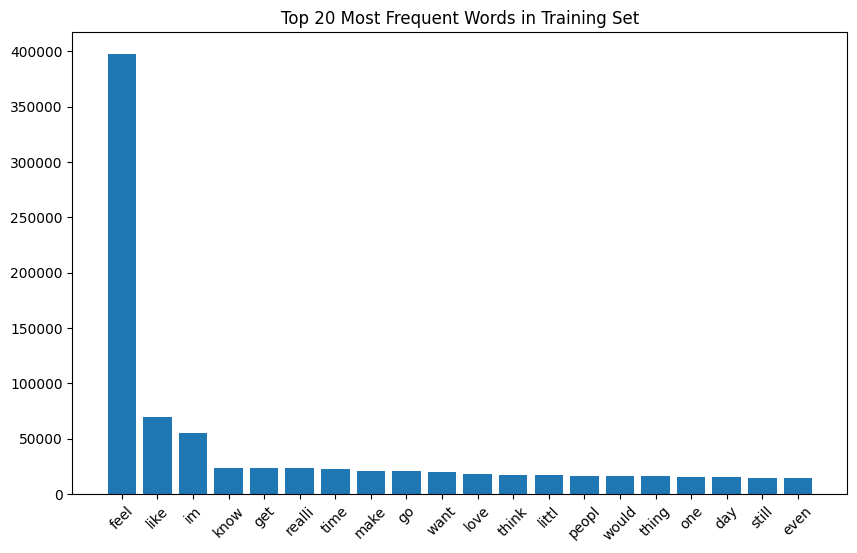

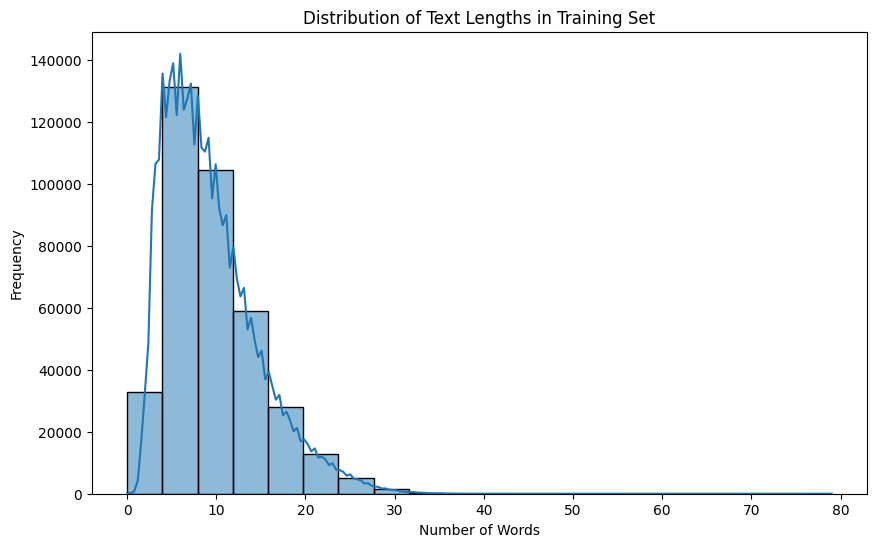

In [6]:
# 1. Word Count Statistics: Calculates total, average, maximum, and minimum word counts for the training data
# A new column 'word_count' to store the number of words in each processed text
train_data['word_count'] = train_data['processed_text'].apply(lambda x: len(x.split()))

# Printing word count statistics for the training set
print("Word Count Statistics:")
print(f"Total words in training set: {train_data['word_count'].sum()}")
print(f"Average words per text: {train_data['word_count'].mean():.2f}")
print(f"Maximum words in a text: {train_data['word_count'].max()}")
print(f"Minimum words in a text: {train_data['word_count'].min()}")

# 2. To extract all unique words from the processed text
vocabulary = set(word for text in train_data['processed_text'] for word in text.split())
print(f"Vocabulary size (unique words): {len(vocabulary)}")

# 3. Most Frequent Words
word_counter = Counter(" ".join(train_data['processed_text']).split())
most_common_words = word_counter.most_common(20)

# Plotting the 20 most common words: A bar plot of the top 20 most common words.
plt.figure(figsize=(10, 6))
words, counts = zip(*most_common_words)
plt.bar(words, counts)
plt.title("Top 20 Most Frequent Words in Training Set")
plt.xticks(rotation=45)
plt.show()

# 4. Text Length Distribution : A histogram showing the distribution of text lengths.
plt.figure(figsize=(10, 6))
sns.histplot(train_data['word_count'], bins=20, kde=True)
plt.title("Distribution of Text Lengths in Training Set")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()



Top 20 Words for Emotion: Fear


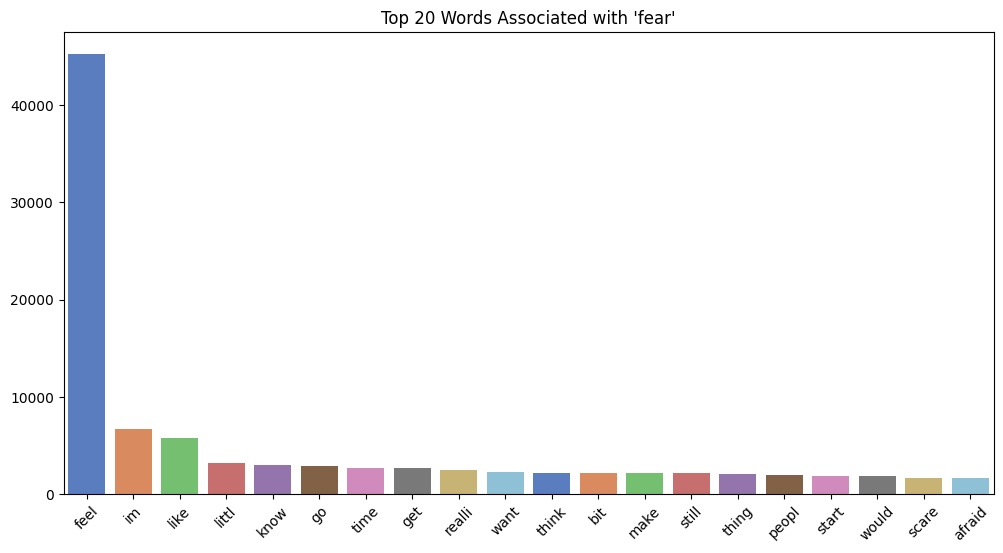

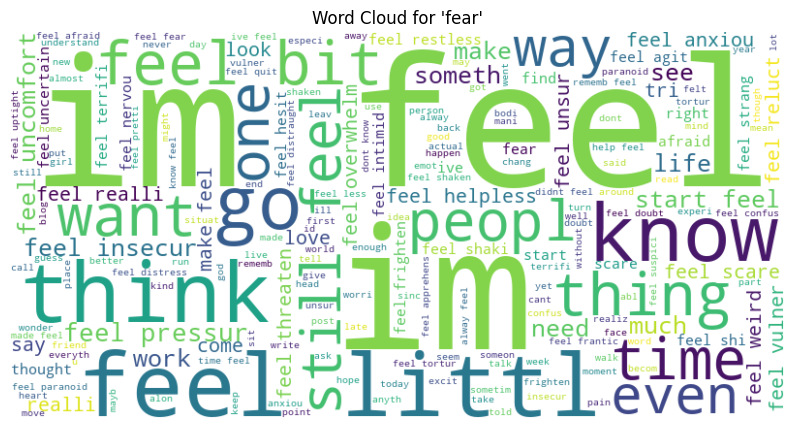


Top 20 Words for Emotion: Sadness


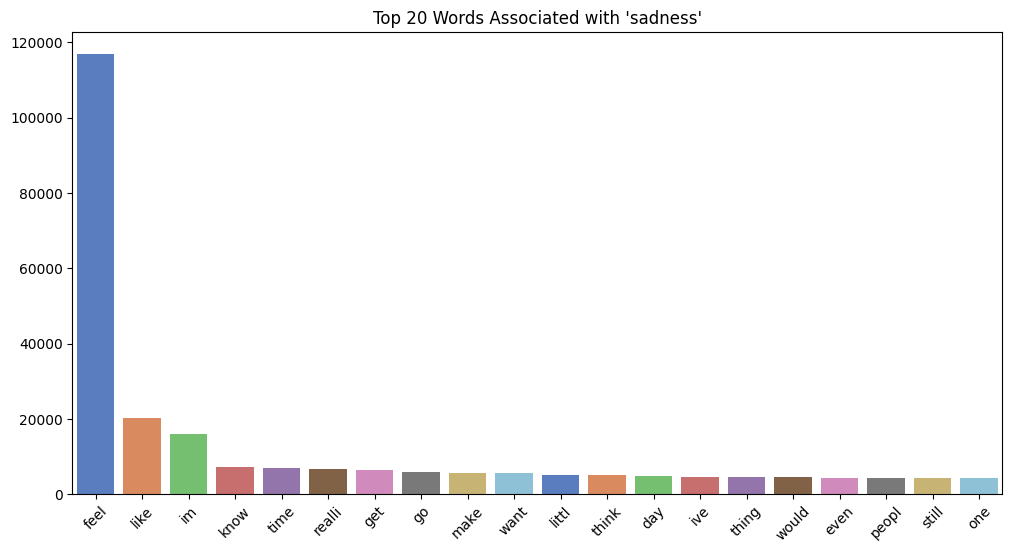

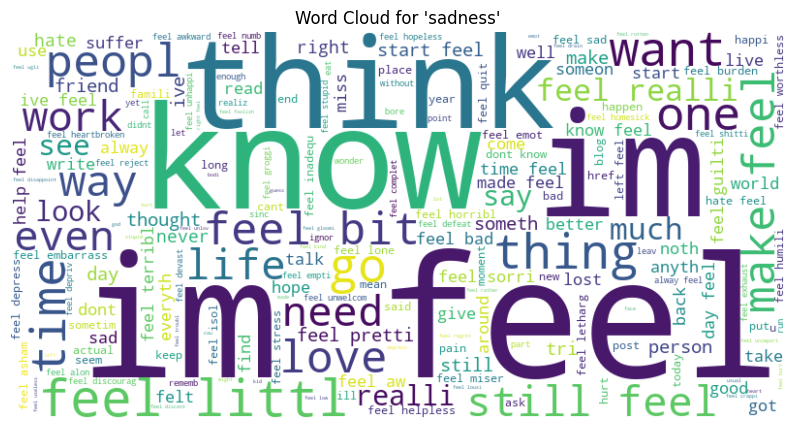


Top 20 Words for Emotion: Love


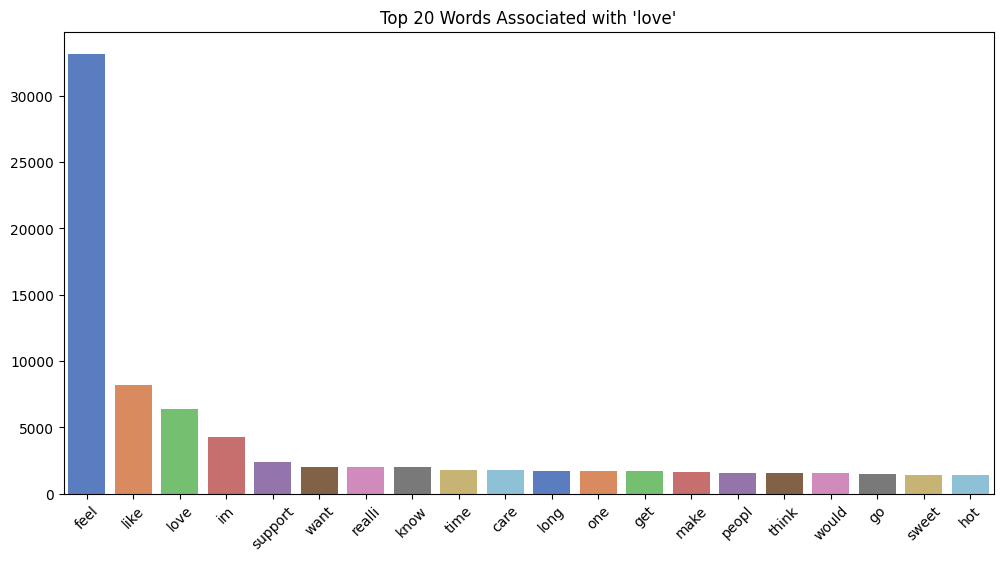

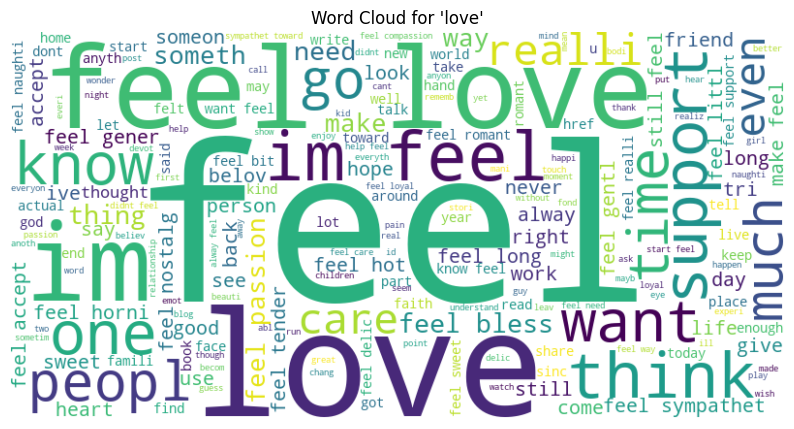


Top 20 Words for Emotion: Joy


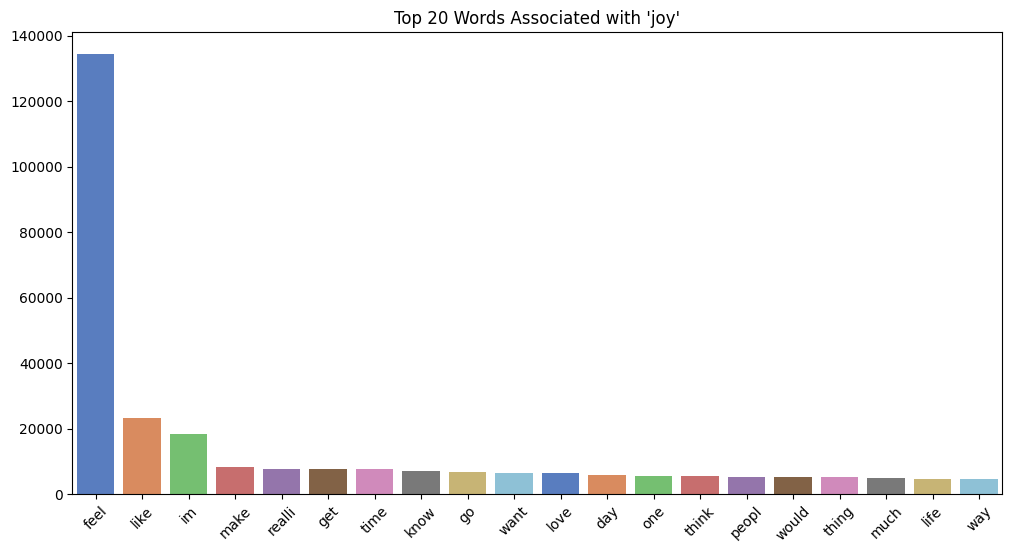

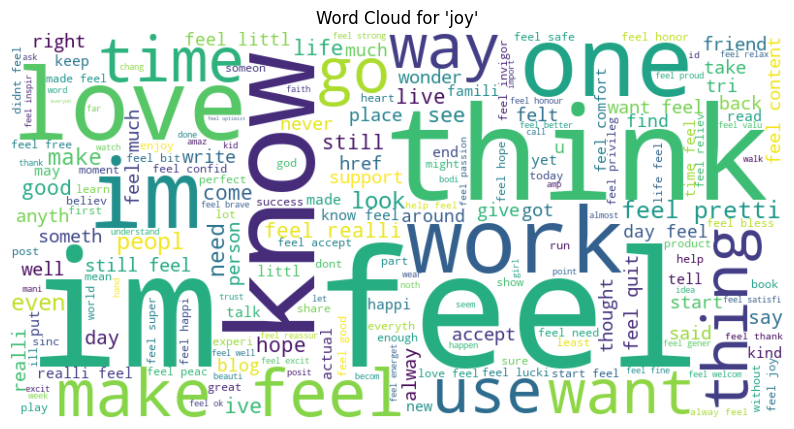


Top 20 Words for Emotion: Surprise


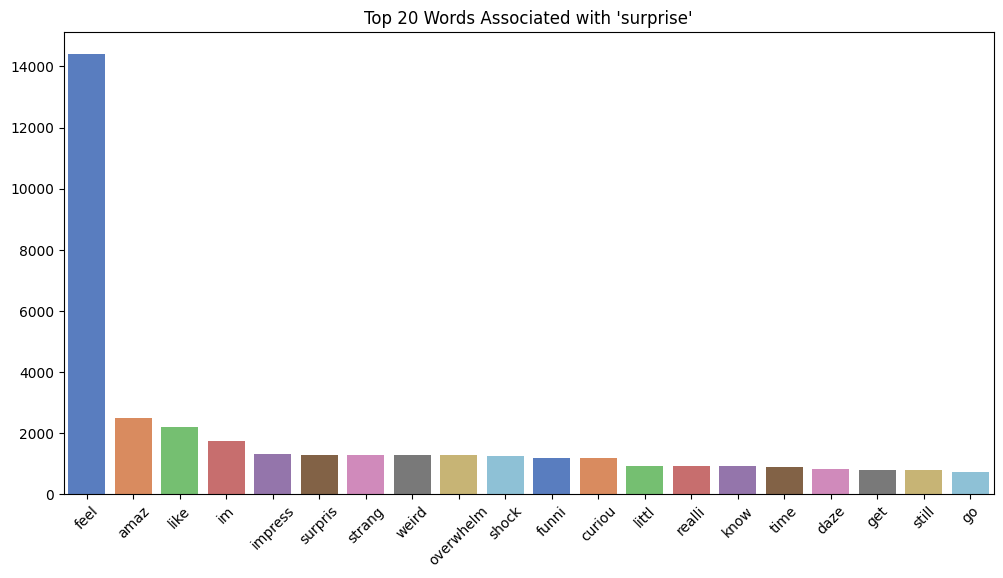

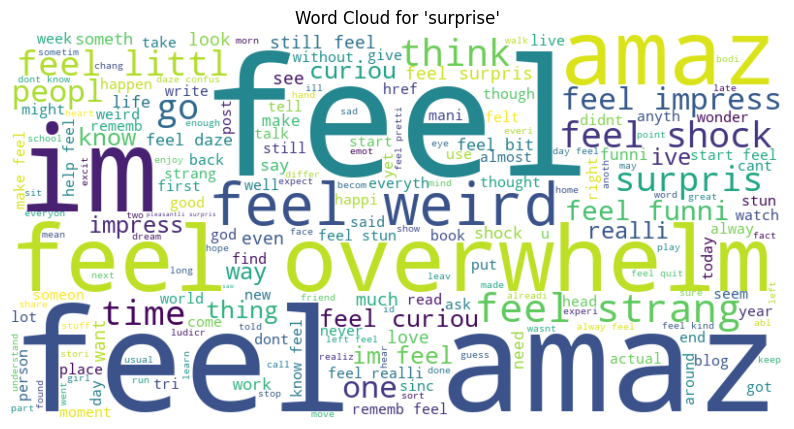


Top 20 Words for Emotion: Anger


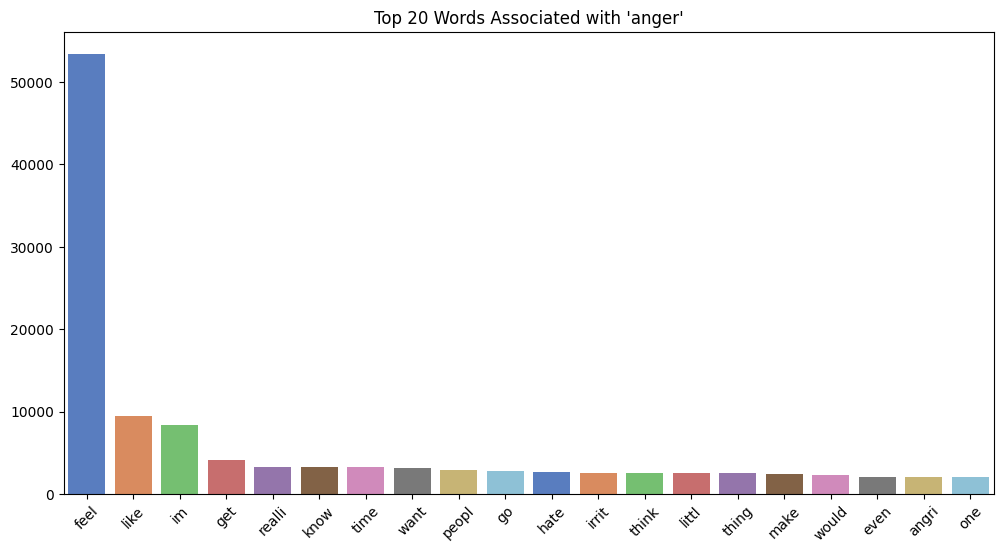

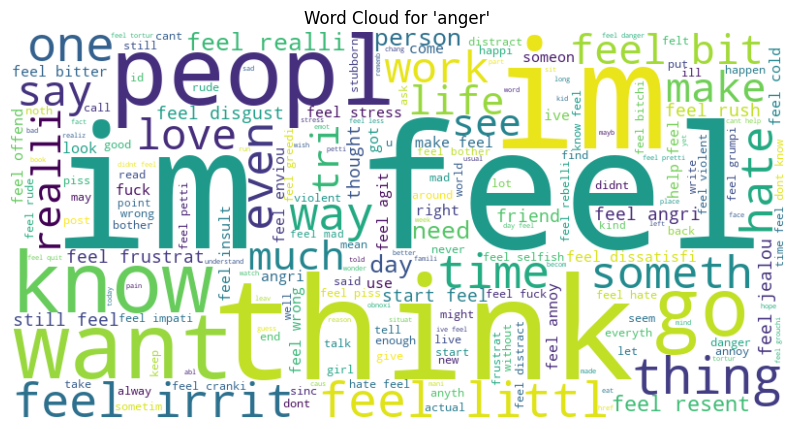

In [7]:
# The emotions 
emotion_map = { 
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

# Function to plot top words
def plot_top_words_for_emotion(data, emotion_label, top_n=20):
    emotion_data = data[data['label'] == emotion_label]
    all_text = " ".join(emotion_data['processed_text'])
    word_counter = Counter(all_text.split())
    top_words = word_counter.most_common(top_n)
    
    words, counts = zip(*top_words)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(words), y=list(counts), palette="muted")
    plt.title(f"Top {top_n} Words Associated with '{emotion_map[int(emotion_label)]}'")
    plt.xticks(rotation=45)
    plt.show()

# Function to generate word cloud
def generate_wordcloud_for_emotion(data, emotion_label):
    emotion_data = data[data['label'] == emotion_label]
    all_text = " ".join(emotion_data['processed_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for '{emotion_map[int(emotion_label)]}'")
    plt.show()

# Visualizing for all emotions
unique_emotions = train_data['label'].unique()
for emotion in unique_emotions:
    print(f"\nTop 20 Words for Emotion: {emotion_map[int(emotion)].capitalize()}")
    plot_top_words_for_emotion(train_data, emotion)
    generate_wordcloud_for_emotion(train_data, emotion)


### Step 4: Building a text classification model, trainning the model on the training set and testing the model on the test set.
#### Model to use XGBoost, XGBClassifier

In [8]:
# Feature Extraction using Bag-of-Words
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_data['processed_text'])
X_test = vectorizer.transform(test_data['processed_text'])
y_train = train_data['label']
y_test = test_data['label']

# Trainnig the Model with XGBoost
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    use_label_encoder=False,  # Disable automatic label encoding
    eval_metric='mlogloss',  # Log Loss as evaluation metric
    random_state=42          # For reproducibility
)

xgb_model.fit(X_train, y_train)  # Trainnong the XGBoost model

# Testing the Model predicting with the XGBoost model
y_pred_xgb = xgb_model.predict(X_test)  


### Step 5: Summarizing the performance of the model 

Classification Report (XGBoost):
              precision    recall  f1-score   support

     sadness       0.93      0.91      0.92     12093
         joy       0.90      0.89      0.89     14052
        love       0.76      0.77      0.76      3500
       anger       0.88      0.88      0.88      5695
        fear       0.88      0.82      0.85      4837
    surprise       0.67      0.92      0.77      1504

    accuracy                           0.88     41681
   macro avg       0.83      0.86      0.85     41681
weighted avg       0.88      0.88      0.88     41681

Overall Model Accuracy (XGBoost): 0.8773
Macro-Averaged Precision: 0.8341
Macro-Averaged Recall: 0.8646
Macro-Averaged F1-Score: 0.8457


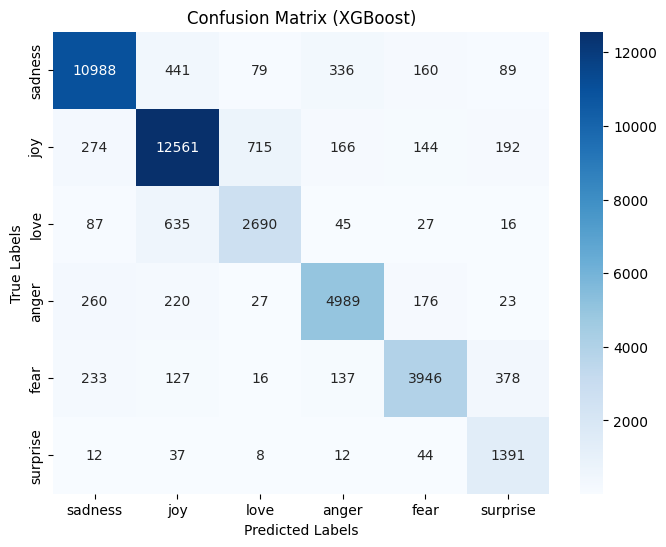

In [9]:
# Importing necessary modules
from sklearn.metrics import precision_score, recall_score, f1_score

# Classification Report for XGBoost
print("Classification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb, target_names=[emotion_map[i] for i in sorted(emotion_map.keys())]))

# Calculating and printing accuracy
accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"Overall Model Accuracy (XGBoost): {accuracy:.4f}")

# Calculating and printing macro-averaged precision, recall, and F1-score
precision_macro = precision_score(y_test, y_pred_xgb, average='macro')
recall_macro = recall_score(y_test, y_pred_xgb, average='macro')
f1_macro = f1_score(y_test, y_pred_xgb, average='macro')

print(f"Macro-Averaged Precision: {precision_macro:.4f}")
print(f"Macro-Averaged Recall: {recall_macro:.4f}")
print(f"Macro-Averaged F1-Score: {f1_macro:.4f}")

# Confusion Matrix for XGBoost
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=[emotion_map[i] for i in sorted(emotion_map.keys())],
            yticklabels=[emotion_map[i] for i in sorted(emotion_map.keys())])
plt.title("Confusion Matrix (XGBoost)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [10]:
# Cross-Validation for Multiple Runs and Standard Deviation of Accuracy, Precision, Recall, and F1

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score

# Defining a Stratified K-Fold cross-validator
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Scoring Metrics
scoring = {
    'accuracy': 'accuracy',  # Adds accuracy scoring
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro')
}

# To run Cross-Validation
accuracy_scores = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring='accuracy')
precision_scores = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring=scoring['precision'])
recall_scores = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring=scoring['recall'])
f1_scores = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring=scoring['f1'])

# Printing Results
print("\nCross-Validation Results (5-Fold Cross-Validation):")
print(f"Accuracy: Mean = {accuracy_scores.mean():.4f}, Std = {accuracy_scores.std():.4f}")
print(f"Precision: Mean = {precision_scores.mean():.4f}, Std = {precision_scores.std():.4f}")
print(f"Recall: Mean = {recall_scores.mean():.4f}, Std = {recall_scores.std():.4f}")
print(f"F1 Score: Mean = {f1_scores.mean():.4f}, Std = {f1_scores.std():.4f}")



Cross-Validation Results (5-Fold Cross-Validation):
Accuracy: Mean = 0.8750, Std = 0.0007
Precision: Mean = 0.8292, Std = 0.0015
Recall: Mean = 0.8629, Std = 0.0013
F1 Score: Mean = 0.8422, Std = 0.0007


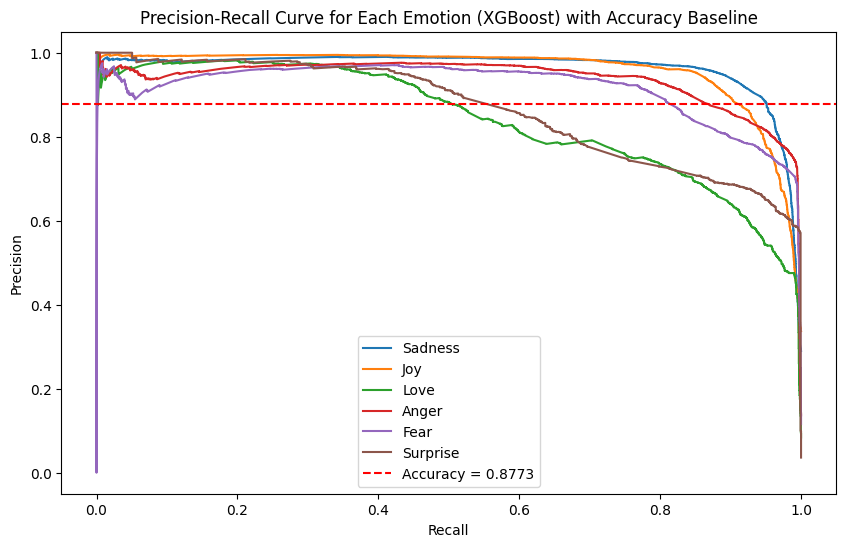

In [11]:
# Precision-Recall Curve for XGBoost

plt.figure(figsize=(10, 6))
for i, emotion in enumerate(xgb_model.classes_):
    precision, recall, _ = precision_recall_curve((y_test == emotion).astype(int), xgb_model.predict_proba(X_test)[:, i])
    plt.plot(recall, precision, label=f"{emotion_map[int(emotion)].capitalize()}")

# Horizontal line for accuracy
plt.axhline(y=accuracy, color='red', linestyle='--', label=f'Accuracy = {accuracy:.4f}')

plt.title("Precision-Recall Curve for Each Emotion (XGBoost) with Accuracy Baseline")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()



### How my model could possibly be improved

### Model Improvements

#### 1. Feature Engineering
- Replacing **Bag-of-Words** with **TF-IDF** for feature extraction to give more importance to meaningful words and reduce the impact of the commonly used ones.
- Experimenting with **n-grams** (e.g., bigrams, trigrams) to capture word sequences and context.

#### 2. Hyperparameter Tuning
- Using **Grid Search** or **Randomized Search** to optimize hyperparameters like:
  - `learning_rate`
  - `max_depth`
  - `n_estimators`
  - `min_child_weight`
- Experimenting with regularization parameters (`lambda`, `alpha`) to reduce overfitting.


